Cointegration p-value: 0.2840


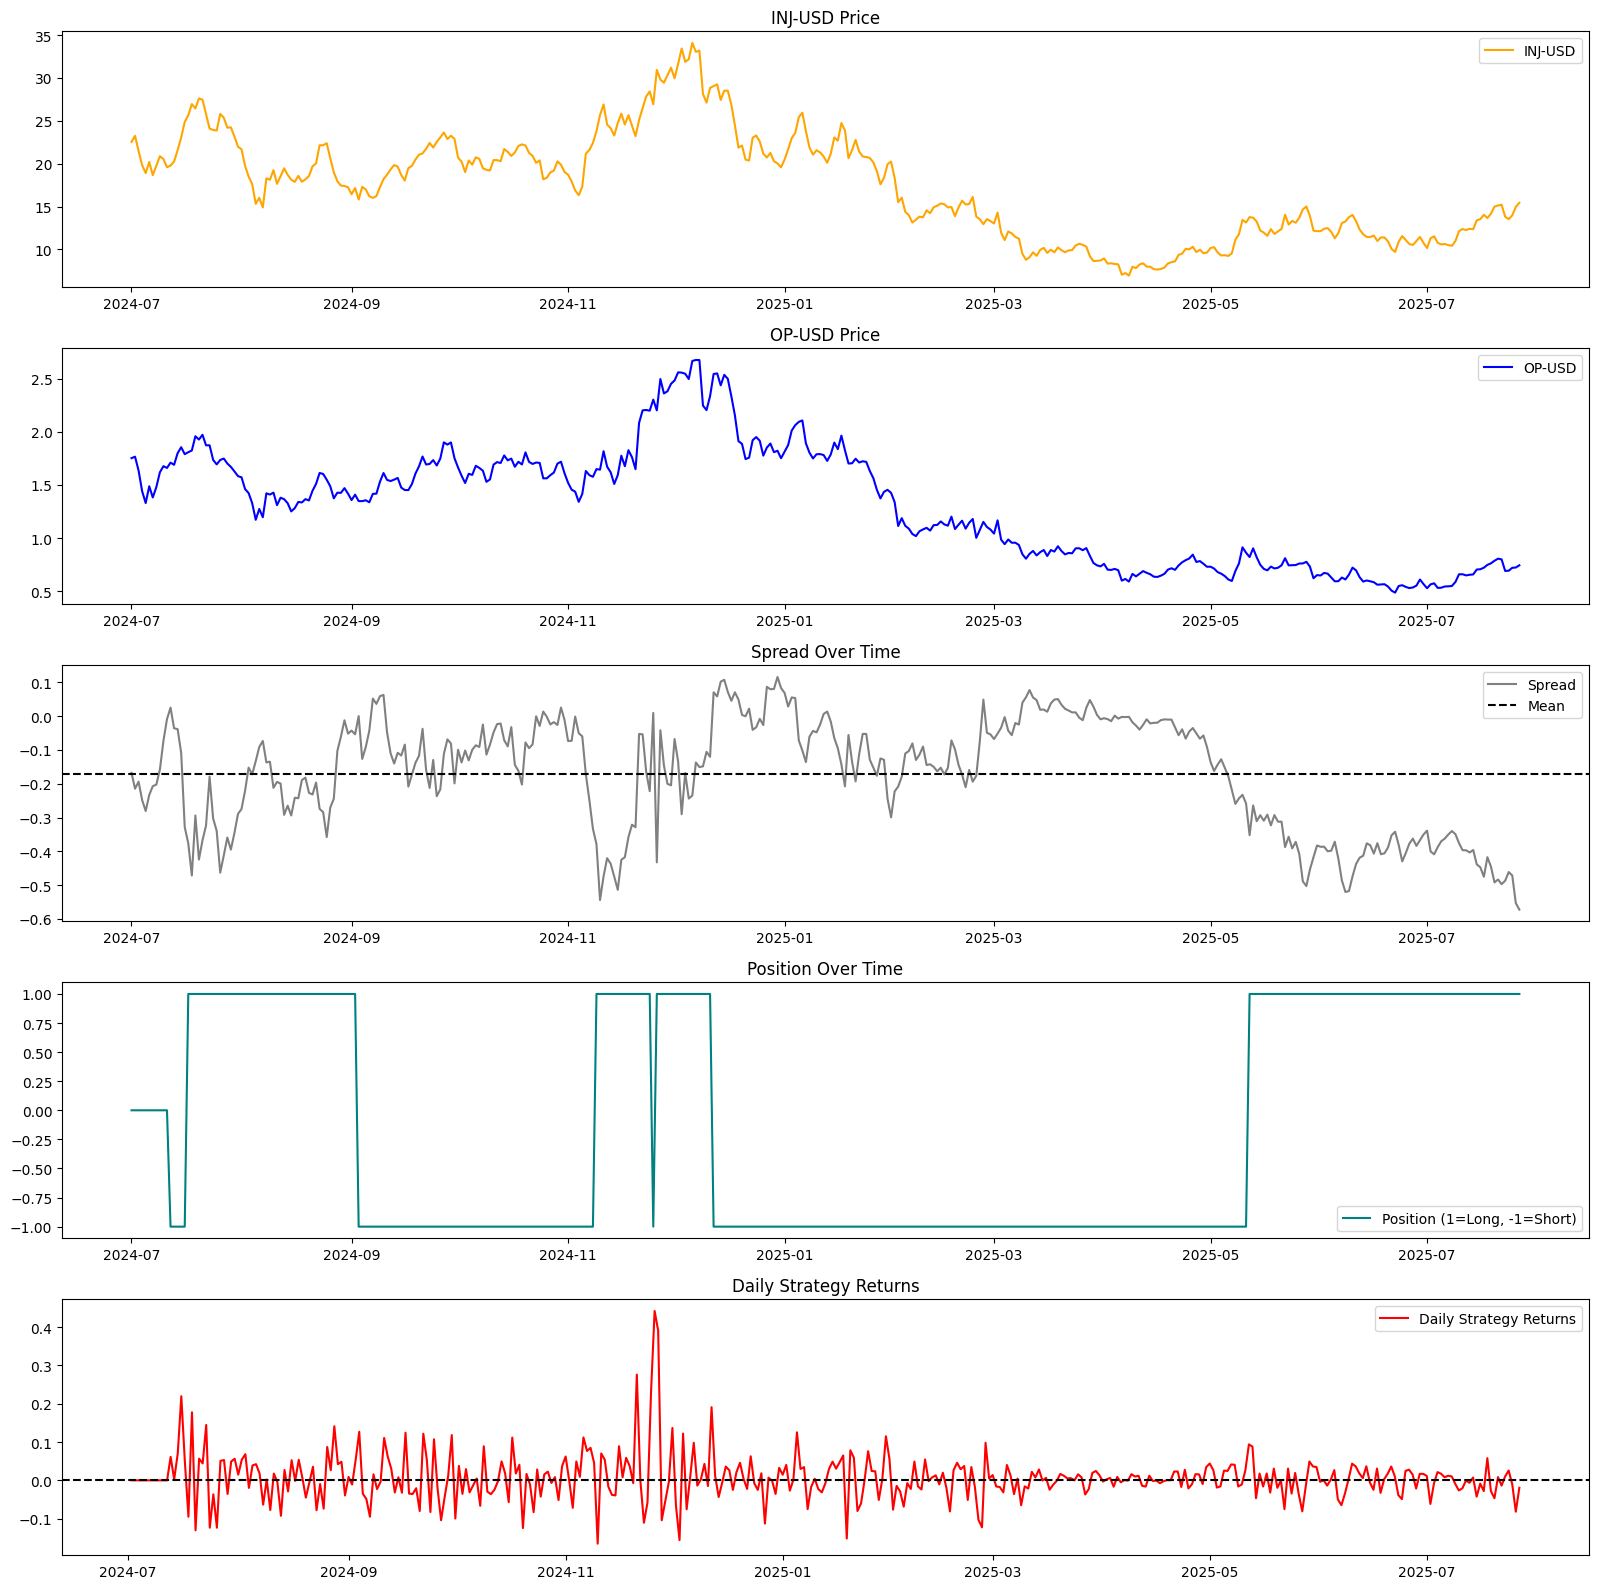

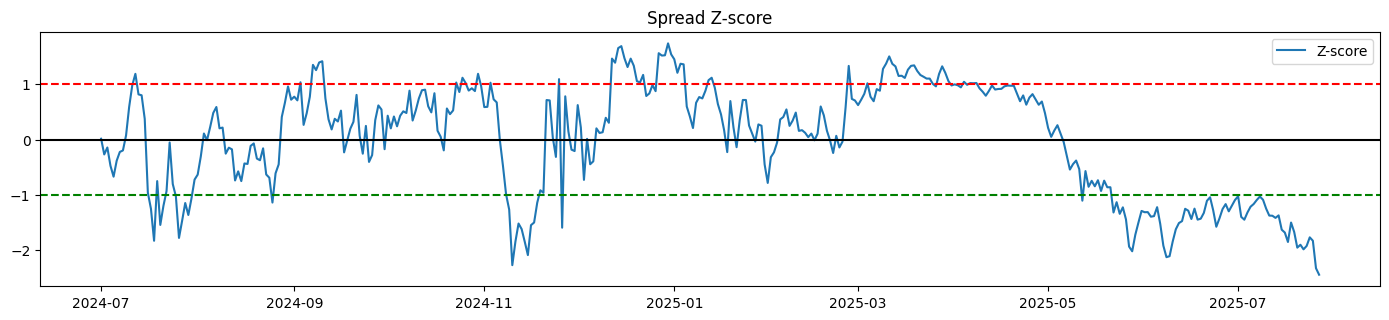

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

def get_data(symbol, start, end):
    df = yf.download(symbol, start=start, end=end, progress=False)
    if df.empty or 'Close' not in df.columns:
        raise ValueError(f"Failed to fetch data or missing 'Close' for {symbol}")
    return df['Close']

# Tickers — customize here
ticker1 = "INJ-USD"
ticker2 = "OP-USD"

# Set your date range
start_date = "2024-07-01"
end_date = "2025-07-29"

# Fetch price data
series1 = get_data(ticker1, start_date, end_date)
series2 = get_data(ticker2, start_date, end_date)

# Combine into single DataFrame
data = pd.concat([series1, series2], axis=1)
data.columns = [ticker1, ticker2]
data.dropna(inplace=True)

# -------------------------------
# 2. Cointegration Test
# -------------------------------
score, pvalue, _ = coint(data[ticker2], data[ticker1])
print(f"Cointegration p-value: {pvalue:.4f}")

# -------------------------------
# 3. Spread and Z-score
# -------------------------------
X = sm.add_constant(data[ticker1])
model = sm.OLS(data[ticker2], X).fit()
hedge_ratio = model.params[ticker1]
data['spread'] = data[ticker2] - hedge_ratio * data[ticker1]
data['zscore'] = (data['spread'] - data['spread'].mean()) / data['spread'].std()

# -------------------------------
# 4. Signal Generation
# -------------------------------
entry_z = 1
exit_z = 0

data['long_signal'] = (data['zscore'] < -entry_z).astype(int)
data['short_signal'] = (data['zscore'] > entry_z).astype(int)
data['exit_signal'] = (abs(data['zscore']) < exit_z).astype(int)

# Position logic
position = []
long = False
short = False

for i in range(len(data)):
    if data['long_signal'].iloc[i] and not long:
        long = True
        short = False
    elif data['short_signal'].iloc[i] and not short:
        short = True
        long = False
    elif data['exit_signal'].iloc[i]:
        long = False
        short = False

    if long:
        position.append(1)
    elif short:
        position.append(-1)
    else:
        position.append(0)

data['position'] = position

# -------------------------------
# 5. P&L Calculation
# -------------------------------
data['spread_change'] = data['spread'].diff()
data['strategy_returns'] = data['position'].shift(1) * data['spread_change']
data['cumulative_returns'] = data['strategy_returns'].cumsum()

# -------------------------------
# 6. Visualization
# -------------------------------
plt.figure(figsize=(16, 16))

# 1. Price Plot 1
plt.subplot(5, 1, 1)
plt.plot(data.index, data[ticker1], label=ticker1, color='orange')
plt.title(f"{ticker1} Price")
plt.legend()

# 2. Price Plot 2
plt.subplot(5, 1, 2)
plt.plot(data.index, data[ticker2], label=ticker2, color='blue')
plt.title(f"{ticker2} Price")
plt.legend()

# 3. Spread
plt.subplot(5, 1, 3)
plt.plot(data.index, data['spread'], label='Spread', color='gray')
plt.axhline(data['spread'].mean(), color='black', linestyle='--', label='Mean')
plt.title("Spread Over Time")
plt.legend()

# 4. Position
plt.subplot(5, 1, 4)
plt.plot(data.index, data['position'], label='Position (1=Long, -1=Short)', color='teal')
plt.title("Position Over Time")
plt.legend()

# 5. Daily Returns
plt.subplot(5, 1, 5)
plt.plot(data.index, data['strategy_returns'], label='Daily Strategy Returns', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Daily Strategy Returns")
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 7. Z-Score & Cumulative Returns
# -------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(2,1,1)
plt.plot(data.index, data['zscore'], label="Z-score")
plt.axhline(entry_z, color='r', linestyle='--')
plt.axhline(-entry_z, color='g', linestyle='--')
plt.axhline(0, color='k', linestyle='-')
plt.title("Spread Z-score")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Set starting capital
starting_capital = 10_000  # $10K

# Define notional position sizes (1 BTC vs hedge_ratio * BNB)
btc_position = 1
bnb_position = hedge_ratio  # from OLS regression

# Calculate notional legs
data['btc_leg'] = data[ticker2] * btc_position
data['bnb_leg'] = data[ticker1] * bnb_position

# Total capital deployed per trade
data['capital_deployed'] = data['btc_leg'] + data['bnb_leg']

# Avoid divide-by-zero
data = data[data['capital_deployed'] > 0]

# PnL per day (based on spread change and position)
data['daily_pnl'] = data['position'].shift(1) * data['spread_change']

# Return as a % of capital deployed
data['daily_return'] = data['daily_pnl'] / data['capital_deployed']

# Scaled PnL in $
data['daily_pnl_$'] = data['daily_return'] * starting_capital

# Cumulative returns
data['cumulative_return'] = (1 + data['daily_return']).cumprod() - 1
data['equity_curve'] = starting_capital * (1 + data['cumulative_return'])

# Define notional position sizes
btc_position = 1
bnb_position = hedge_ratio  # same as used in regression

# Calculate notional values
data['btc_leg'] = data[ticker2] * btc_position
data['bnb_leg'] = data[ticker1] * bnb_position

# Total capital deployed per trade (long one, short the other)
data['capital_deployed'] = data['btc_leg'] + data['bnb_leg']

# Safe guard against zeros
data = data[data['capital_deployed'] > 0]

# PnL per day = position (1/-1/0) * spread change
data['daily_pnl'] = data['position'].shift(1) * data['spread_change']

# Return as a % of capital deployed
data['daily_return'] = data['daily_pnl'] / data['capital_deployed']

# Cumulative return in %
data['cumulative_return'] = (1 + data['daily_return']).cumprod() - 1


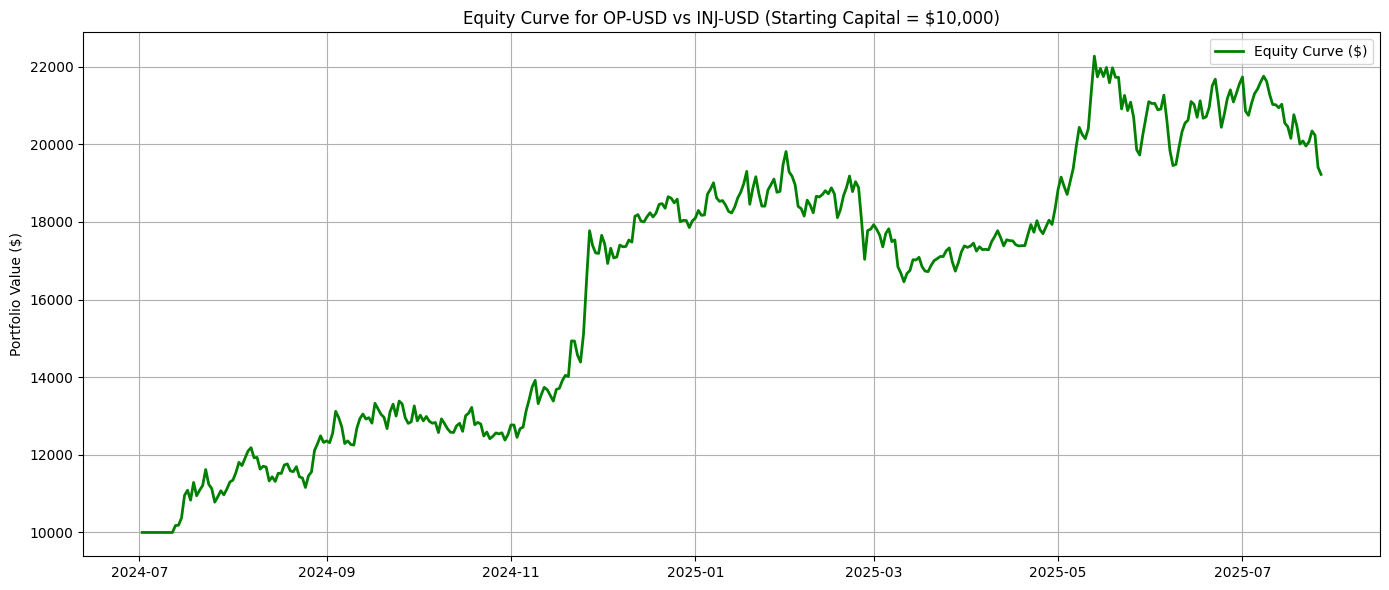

In [8]:
# Plot both
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['equity_curve'], label='Equity Curve ($)', color='green', linewidth=2)
plt.title(f"Equity Curve for {ticker2} vs {ticker1} (Starting Capital = ${starting_capital:,})")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

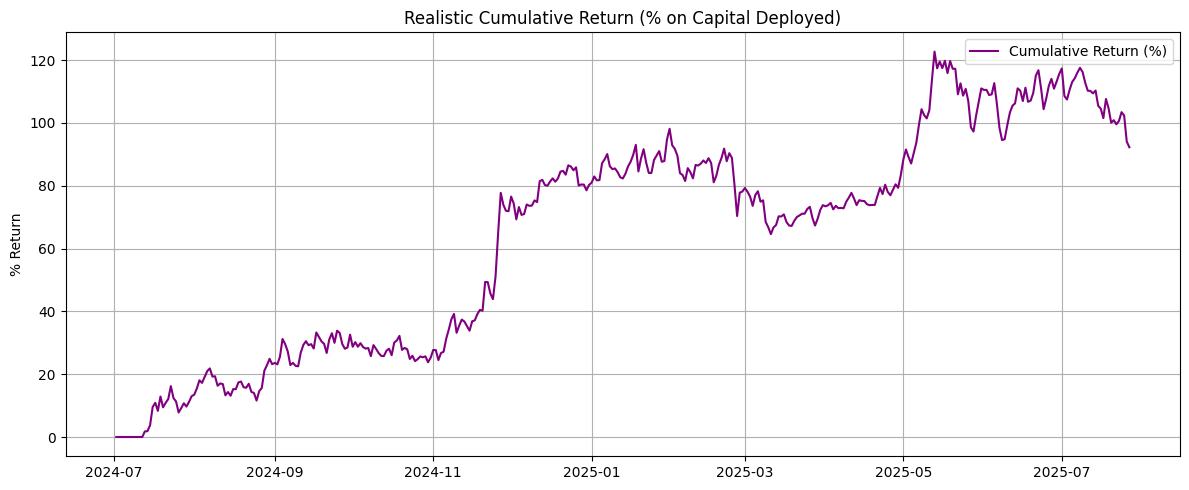

In [9]:


# Plot new returns
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['cumulative_return'] * 100, label='Cumulative Return (%)', color='purple')
plt.title("Realistic Cumulative Return (% on Capital Deployed)")
plt.ylabel("% Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
